# Phase 4 project

Topic 4: Natural Language Processing (NLP)
If you choose this option, you'll build an NLP model to analyze Twitter sentiment about Apple and Google products. The dataset comes from CrowdFlower via data.world. Human raters rated the sentiment in over 9,000 Tweets as positive, negative, or neither.

Your task is to:

Build a model that can rate the sentiment of a Tweet based on its content.

Aim for a Proof of Concept
There are many approaches to NLP problems - start with something simple and iterate from there. For example, you could start by limiting your analysis to positive and negative Tweets only, allowing you to build a binary classifier. Then you could add in the neutral Tweets to build out a multiclass classifier. You may also consider using some of the more advanced NLP methods in the Mod 4 Appendix.

Evaluation
Evaluating multiclass classifiers can be trickier than binary classifiers because there are multiple ways to mis-classify an observation, and some errors are more problematic than others. Use the business problem that your NLP project sets out to solve to inform your choice of evaluation metrics.

## Summary
The notebook should include a summary at the beginning that briefly and accurately describes your process. The summary should be approximately 250 words -- about the size of a research paper abstract.

# Notes:

|  ||
|:-----|:----:|
|lines total     |9093     |
|have "directed_at" product  |3291     |


|Sentiment  |Count|
|:-----|:----:|
|No emotion toward brand or product     |5389     |
|Positive emotion     |2978     |
|Negative emotion     |570     |
|I can't tell     |156     |


iPad                               946<br>
Apple                              661<br>
iPad or iPhone App                 470<br>
Google                             430<br>
iPhone                             297<br>
Other Google product or service    293<br>
Android App                         81<br>
Android                             78<br>
Other Apple product or service      35




---
## Part 1: KNN + Pipelines [Suggested time: 20 minutes]
---

In [1]:
# Run this cell without changes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, silhouette_score

from sklearn.model_selection import train_test_split, GridSearchCV
from keras import models
from keras import layers
from keras import optimizers

from keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical

import nltk
import re
nltk.download('punkt')
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

from sklearn.cluster import KMeans

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mleroi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mleroi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_csv('judge-1377884607_tweet_product_company.csv', encoding='latin1')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [3]:
processed_df=df.dropna(subset=['tweet_text']).copy()
processed_df.drop_duplicates(subset=['tweet_text'], inplace=True)

In [4]:
processed_df

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product


In [5]:
processed_df['emotion_in_tweet_is_directed_at'].value_counts()

iPad                               943
Apple                              659
iPad or iPhone App                 469
Google                             428
iPhone                             296
Other Google product or service    293
Android App                         80
Android                             77
Other Apple product or service      35
Name: emotion_in_tweet_is_directed_at, dtype: int64

In [6]:
processed_df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

No emotion toward brand or product    5372
Positive emotion                      2968
Negative emotion                       569
I can't tell                           156
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

In [7]:
pos_neg_df = processed_df[(processed_df['is_there_an_emotion_directed_at_a_brand_or_product'] == 'Positive emotion') | (processed_df['is_there_an_emotion_directed_at_a_brand_or_product'] == 'Negative emotion')]
pos_neg_df

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
9077,@mention your PR guy just convinced me to swit...,iPhone,Positive emotion
9079,&quot;papyrus...sort of like the ipad&quot; - ...,iPad,Positive emotion
9080,Diller says Google TV &quot;might be run over ...,Other Google product or service,Negative emotion
9085,I've always used Camera+ for my iPhone b/c it ...,iPad or iPhone App,Positive emotion


In [8]:
# Raw text complaints
pos_neg_tweets = pos_neg_df['tweet_text'] 

# Initialize a tokenizer 
tokenizer = Tokenizer(num_words=2000) 

# Fit it to the tweets
tokenizer.fit_on_texts(pos_neg_tweets) 

# Similar to sequences, but returns a numpy array
one_hot_results= tokenizer.texts_to_matrix(pos_neg_tweets, mode='binary') 

# Useful if we wish to decode (more explanation below)
word_index = tokenizer.word_index 

# Tokens are the number of unique words across the corpus
print('Found %s unique tokens.' % len(word_index)) 

# Our coded data
print('Dimensions of our coded results:', np.shape(one_hot_results)) 
one_hot_results


Found 6230 unique tokens.
Dimensions of our coded results: (3537, 2000)


array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [9]:
sorted_word_list = sorted(tokenizer.word_counts.items(), key=lambda item: item[1], reverse=True)
print(sorted_word_list[0:20])

[('sxsw', 3686), ('mention', 2505), ('the', 1903), ('to', 1413), ('link', 1316), ('ipad', 1206), ('at', 1162), ('rt', 1071), ('for', 1027), ('apple', 1003), ('a', 950), ('google', 825), ('is', 802), ('of', 771), ('in', 759), ('iphone', 702), ('and', 677), ('quot', 639), ('store', 595), ('i', 582)]


In [10]:
# pos_neg_sentiment = [1 for sent in pos_neg_df['is_there_an_emotion_directed_at_a_brand_or_product']]
# len(pos_neg_sentiment)

pos_neg_sentiment = pos_neg_df['is_there_an_emotion_directed_at_a_brand_or_product']

# Initialize
le = LabelEncoder() 
le.fit(pos_neg_sentiment)
print('Original class labels:')
print(list(le.classes_))
print('\n')
pos_neg_sentiment_cat = le.transform(pos_neg_sentiment)  

# If you wish to retrieve the original descriptive labels post production
# list(le.inverse_transform([0, 1, 3, 3, 0, 6, 4])) 

print('New product labels:')
print(pos_neg_sentiment_cat)
print('\n')

# Each row will be all zeros except for the category for that observation 
print('One hot labels; 2 binary columns, one for each of the categories.') 
pos_neg_sentiment_onehot = to_categorical(pos_neg_sentiment_cat)
print(pos_neg_sentiment_onehot)
print('\n')

print('One hot labels shape:')
print(np.shape(pos_neg_sentiment_onehot))

Original class labels:
['Negative emotion', 'Positive emotion']


New product labels:
[0 1 1 ... 0 1 1]


One hot labels; 2 binary columns, one for each of the categories.
[[1. 0.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [0. 1.]
 [0. 1.]]


One hot labels shape:
(3537, 2)


In [11]:
X_train_full, X_test, y_train_full, y_test = train_test_split(one_hot_results,pos_neg_sentiment_onehot, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [12]:
# Initialize a sequential model
model = models.Sequential()

# Two layers with relu activation
model.add(layers.Dense(50, activation='relu', input_shape=(2000,)))
model.add(layers.Dense(25, activation='relu'))

# One layer with softmax activation 
model.add(layers.Dense(2, activation='softmax'))

In [13]:
model.compile(optimizer='SGD',loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
history = model.fit(X_train,
                    y_train,
                    epochs=120,
                    batch_size=256,
                    validation_data=(X_val, y_val))

Epoch 1/120
10/10 [==============================] - 0s 21ms/step - loss: 0.6449 - accuracy: 0.8032 - val_loss: 0.6159 - val_accuracy: 0.8405
Epoch 2/120
10/10 [==============================] - 0s 8ms/step - loss: 0.5970 - accuracy: 0.8403 - val_loss: 0.5731 - val_accuracy: 0.8372
Epoch 3/120
10/10 [==============================] - 0s 7ms/step - loss: 0.5562 - accuracy: 0.8407 - val_loss: 0.5371 - val_accuracy: 0.8372
Epoch 4/120
10/10 [==============================] - 0s 10ms/step - loss: 0.5226 - accuracy: 0.8407 - val_loss: 0.5083 - val_accuracy: 0.8372
Epoch 5/120
10/10 [==============================] - 0s 7ms/step - loss: 0.4962 - accuracy: 0.8407 - val_loss: 0.4861 - val_accuracy: 0.8372
Epoch 6/120
10/10 [==============================] - 0s 7ms/step - loss: 0.4757 - accuracy: 0.8407 - val_loss: 0.4704 - val_accuracy: 0.8372
Epoch 7/120
10/10 [==============================] - 0s 8ms/step - loss: 0.4612 - accuracy: 0.8407 - val_loss: 0.4590 - val_accuracy: 0.8372
Epoch 8/120

Epoch 59/120
10/10 [==============================] - 0s 7ms/step - loss: 0.3948 - accuracy: 0.8407 - val_loss: 0.4145 - val_accuracy: 0.8372
Epoch 60/120
10/10 [==============================] - 0s 7ms/step - loss: 0.3942 - accuracy: 0.8407 - val_loss: 0.4141 - val_accuracy: 0.8372
Epoch 61/120
10/10 [==============================] - 0s 6ms/step - loss: 0.3935 - accuracy: 0.8407 - val_loss: 0.4137 - val_accuracy: 0.8372
Epoch 62/120
10/10 [==============================] - 0s 7ms/step - loss: 0.3928 - accuracy: 0.8407 - val_loss: 0.4133 - val_accuracy: 0.8372
Epoch 63/120
10/10 [==============================] - 0s 6ms/step - loss: 0.3922 - accuracy: 0.8407 - val_loss: 0.4130 - val_accuracy: 0.8372
Epoch 64/120
10/10 [==============================] - 0s 6ms/step - loss: 0.3915 - accuracy: 0.8407 - val_loss: 0.4126 - val_accuracy: 0.8372
Epoch 65/120
10/10 [==============================] - 0s 6ms/step - loss: 0.3909 - accuracy: 0.8407 - val_loss: 0.4122 - val_accuracy: 0.8372
Epoch 

10/10 [==============================] - 0s 7ms/step - loss: 0.3545 - accuracy: 0.8407 - val_loss: 0.3927 - val_accuracy: 0.8372
Epoch 117/120
10/10 [==============================] - 0s 7ms/step - loss: 0.3537 - accuracy: 0.8407 - val_loss: 0.3922 - val_accuracy: 0.8372
Epoch 118/120
10/10 [==============================] - 0s 7ms/step - loss: 0.3528 - accuracy: 0.8407 - val_loss: 0.3919 - val_accuracy: 0.8372
Epoch 119/120
10/10 [==============================] - 0s 7ms/step - loss: 0.3521 - accuracy: 0.8407 - val_loss: 0.3915 - val_accuracy: 0.8372
Epoch 120/120
10/10 [==============================] - 0s 7ms/step - loss: 0.3513 - accuracy: 0.8407 - val_loss: 0.3912 - val_accuracy: 0.8372


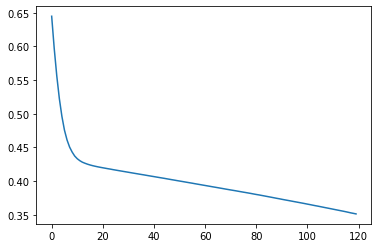

In [15]:
# Plot the loss vs the number of epoch
plt.plot(history.history['loss']);

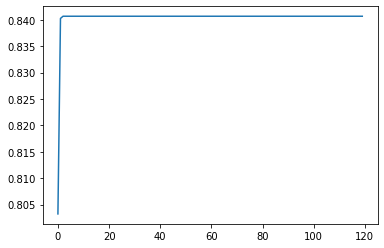

In [16]:
# Plot the training accuracy vs the number of epochs
plt.plot(history.history['accuracy']);

In [17]:
# Print the loss and accuracy for the training set 
results_train = model.evaluate(X_train, y_train)
results_train

76/76 [==============================] - 0s 1ms/step - loss: 0.3506 - accuracy: 0.8407


[0.3505896329879761, 0.8406822085380554]

In [18]:
# Print the loss and accuracy for the test set 
results_val = model.evaluate(X_val, y_val)
results_val

19/19 [==============================] - 0s 2ms/step - loss: 0.3912 - accuracy: 0.8372


[0.39117908477783203, 0.8372092843055725]

things to add:

stopwords
lemmetize

tune: 

layers, num_words, epochs

In [ ]:
pipe = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("model", LogisticRegression())
])

In [19]:
# REGEX code for 3+ characters:    r"(?u)\w{3,}"